# Maptember (Mapvember?) 2023
Most of the time it feels like I'm whispering into a void on social media these days, so this, dear mapmakers, is now a selfish exercise. As usual, many thanks for Topi [for putting this challenge together](https://30daymapchallenge.com/)

This year will be a.) a late start, and b.) a beginner-brain attempt to create all the maps in a python notebook. My comfort level with the medium has risen in recent years, but there's nothing quite like a 30-day map challenge to force me to learn new tricks. On we go.

## The tasks
![challenges](https://raw.githubusercontent.com/tjukanovt/30DayMapChallenge/main/images/flyers/30dmc-2023.png)

## The groundwork
As usual I'll need a good data source, and perhaps a settled geographic location. I've done Vermont and Montreal in the past, but the themes seem to take us around the globe this year, so I'll plan to use [Natural Earth data](https://www.naturalearthdata.com/) wherever possible.

There will also be something of a pileup of standard libraries for this project, and I'll begin importing them here

In [1]:
%%capture 
# Set up the environment
!python3 -m venv venv
!source venv/bin/activate

In [28]:
%%capture 
# Import necessities
!pip install pandas
!pip install geopandas
!pip install geodatasets
!pip install contextily
!pip install networkx
!pip install osmnx
# %matplotlib nbagg
!pip install matplotlib

In [33]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, Polygon

In [3]:
# Define some data sources
url_ne_pop_places_10 = "http://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_populated_places.zip"
url_ne_geo_lines_10 = "http://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip"
url_ne_land_110 = "http://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip"
url_ne_admin_0_110 = "http://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

## Day 1: Points
Starting with global populated places . . .

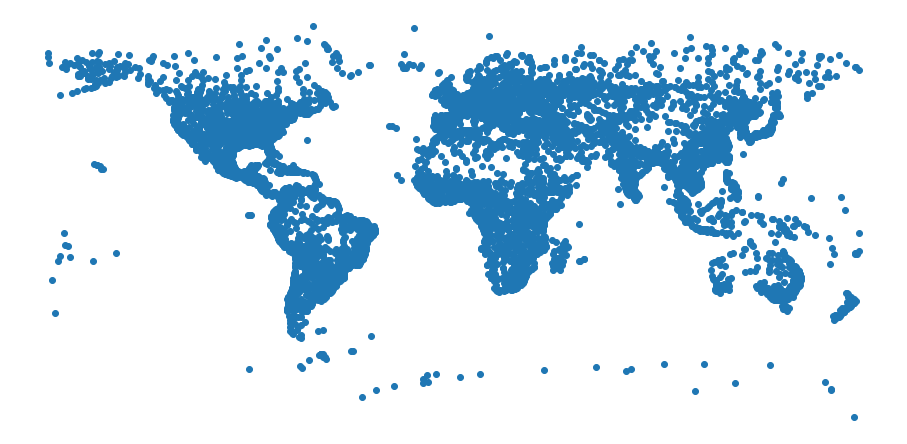

In [5]:
gdf_ne_pop_places_10 = gpd.read_file(url_ne_pop_places_10)
gdf_ne_pop_places_10.plot(figsize=[16,8]).set_axis_off()

Wow, that was easy. Let's move on.

## Day 2: Lines

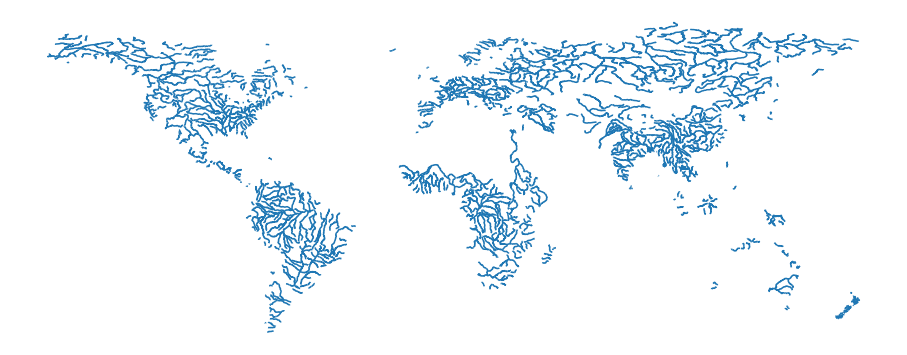

In [6]:
gdf_ne_geo_lines_10 = gpd.read_file(url_ne_geo_lines_10)
gdf_ne_geo_lines_10.plot(figsize=[16,8]).set_axis_off()

Waterways!

## Day 3: Polygons

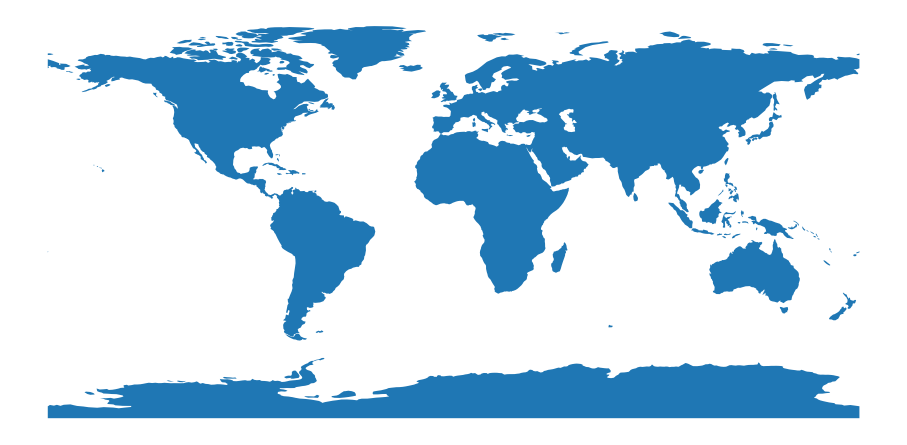

In [7]:
gdf_ne_land_110 = gpd.read_file(url_ne_land_110)
gdf_ne_land_110.plot(figsize=[16,8]).set_axis_off()

Oh hey, that's an actual map of some recognizeable things!

## Day 4: A bad map

Strictly speaking, all the maps so far have been "bad maps" - I'm deliberately going slow and avoiding adornment. But let's try to mess things up deliberately so that I can add something to my "Cursed maps" series.

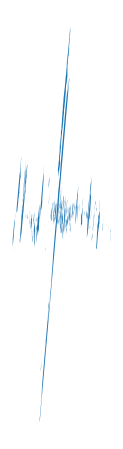

In [8]:
gdf_ne_admin_0_110 = gpd.read_file(url_ne_admin_0_110)
gsr_ne_admin_0_110 = GeoSeries(gdf_ne_admin_0_110.geometry)
gsr_ne_admin_0_110.skew(10, 70).rotate(15).plot(figsize=[16,8]).set_axis_off()

Fabulous. Looks more like a North arrow.

## Day 5: Analog map

> an·a·log - /ˈanlˌôɡ,ˈanlˌäɡ/
> _adjective_
> relating to or using signals or information represented by a continuously variable physical quantity such as spatial position, voltage, etc.
> _"analog signals"_

So we'll make a typewriter-style map.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


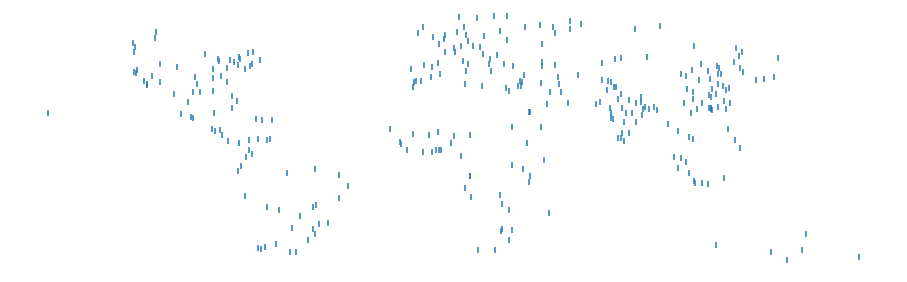

In [9]:
gdf_ne_pop_places_10 = gpd.read_file(url_ne_pop_places_10)
gdf_ne_pop_places_10_scale2 = gdf_ne_pop_places_10[
    (gdf_ne_pop_places_10['SCALERANK'] <= 3) &
    (gdf_ne_pop_places_10['POP1950'] > 0) &
    (gdf_ne_pop_places_10['POP2050'] > 0)
]

gdf_ne_pop_places_10_scale2['delta'] = (gdf_ne_pop_places_10_scale2['POP2050'] - gdf_ne_pop_places_10_scale2['POP1950']) * 1000

max_delta = gdf_ne_pop_places_10_scale2['delta'].max()

gdf_ne_pop_places_10_scale2.plot(
    figsize=[16,8],
    marker=2
    #column=char
).set_axis_off()

## Day 6: Asia

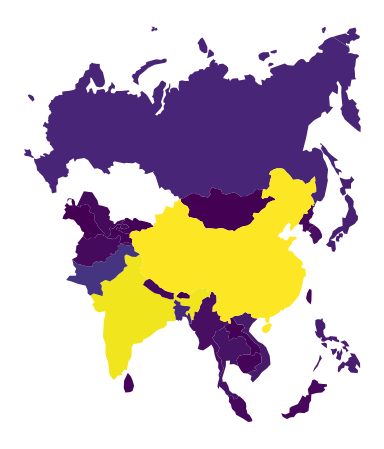

In [42]:
gdf_ne_admin_0_110 = gpd.read_file(url_ne_admin_0_110)
gdf_ne_admin_0_110.columns.values
asia_set = ['AFG', 'BGD', 'BTN', 'CH1', 'IND', 'JPN', 'KAZ', 'KGZ', 'KHM', 'KOR', 'LAO', 'LKA', 'MMR', 'MNG', 'MYS', 'NPL', 'PAK', 'PHL', 'PRK', 'RUS', 'THA', 'TJK', 'TKM', 'TWN', 'UZB', 'VNM']

gdf_ne_admin_0_110_asia = gdf_ne_admin_0_110[gdf_ne_admin_0_110['SOV_A3'].isin(asia_set)]

gdf_ne_admin_0_110_asia = gdf_ne_admin_0_110_asia.to_crs("ESRI:102027")

gdf_ne_admin_0_110_asia.plot(
    figsize=[16,8],
    column="POP_EST"
).set_axis_off()

No idea where Kazakhstan went, and no time to find out.

## Day 7: Navigation
Many thanks to Cesar Cheng [for this great 15 minute city example](https://medium.com/@cheng.cesar/15-min-city-8c00dbe279fc) - I've adapted it to focus on Huy, Belgium.

In [36]:
place = 'Huy, Belgium'
network_type = 'walk'
trip_times = [5,10,15,25] # in minutes
travel_speed = 4.5 #walking speed in km/hour
Graph = ox.graph_from_address(place,network_type=network_type)

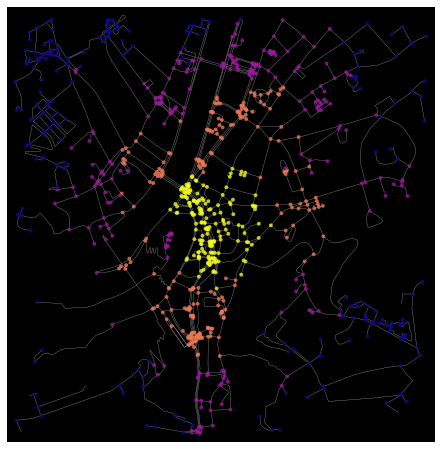

In [37]:
grand_place = (50.518090631766746, 5.2409010386558705)
center_node = ox.get_nearest_node(Graph,grand_place)

meters_per_minute = travel_speed * 1000 / 60 
for u, v, k, data in Graph.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute
    
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(Graph, center_node, radius=trip_time,  distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in Graph.nodes()]
ns = [15 if node in node_colors else 0 for node in Graph.nodes()]
# plot graph
fig, ax = ox.plot_graph(Graph, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,bgcolor='k', edge_linewidth=0.2, edge_color='#999999')

## Day 8: Africa

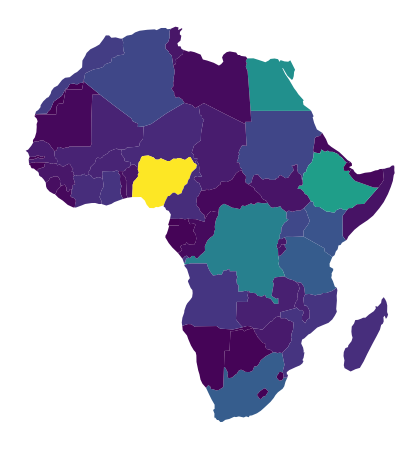

In [41]:
gdf_ne_admin_0_110 = gpd.read_file(url_ne_admin_0_110)
gdf_ne_admin_0_110.columns.values
africa_set = ['AGO', 'BDI', 'BEN', 'BFA', 'BWA', 'CAF', 'CIV', 'CMR', 'COD', 'COG', 'DJI', 'DZA', 'EGY', 'ERI', 'ETH', 'GAB', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'KEN', 'LBR', 'LBY', 'LSO', 'MAR', 'MDG', 'MLI', 'MOZ', 'MRT', 'MWI', 'NAM', 'NER', 'NGA', 'RWA', 'SAH', 'SDN', 'SDS', 'SEN', 'SLE', 'SOL', 'SOM', 'SWZ', 'TCD', 'TGO', 'TUN', 'TZA', 'UGA', 'ZAF', 'ZMB', 'ZWE']

gdf_ne_admin_0_110_africa = gdf_ne_admin_0_110[gdf_ne_admin_0_110['SOV_A3'].isin(africa_set)]

gdf_ne_admin_0_110_africa = gdf_ne_admin_0_110_africa.to_crs("ESRI:102011")

gdf_ne_admin_0_110_africa.plot(
    figsize=[16,8],
    column="POP_EST"
).set_axis_off()

## Day 9: Hexagons

## Day 10: North America

## Day 11: Retro

## Day 12: South America

## Day 13: Choropleth

## Day 14: Europe

In [14]:
import geopandas
import geodatasets
import contextily as cx

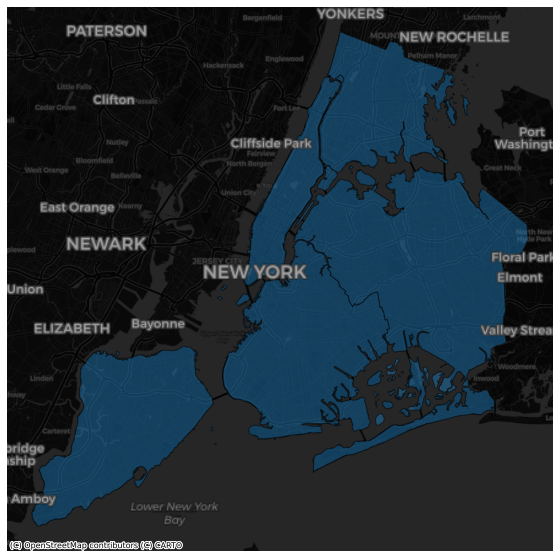

In [27]:
df = geopandas.read_file(geodatasets.get_path("nybb"))
df_wm = df.to_crs(epsg=3857)

ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatter)
cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterOnlyLabels, zoom=10)
ax.set_axis_off()